In [139]:
import torch

from models.normalizing_flow import HierarchicalNormalizingFlow

from models.planar import planar
import matplotlib.pyplot as plt
import os
import numpy as np

torch.set_grad_enabled(False)


In [140]:

flows = planar(input_dim=1, num_layers=8)

In [141]:
# model = HierarchicalNormalizingFlow.load_from_checkpoint('../local_runs/run_1/epoch=118-step=1785.ckpt', flows=flows)

# boundaries = (-3, 3)
# resolution = 256
# d = 1
# normalize = False
# keys = None

# grid = torch.linspace(*boundaries, resolution)
# d_grid = [grid] * d
# meshgrid = torch.meshgrid(*d_grid, indexing="xy")
# x = torch.stack(meshgrid).reshape(d, -1).permute(1, 0)
# shape = [resolution] * d
# prob = model.log_prob(x).exp().view(*shape)


# d_grid = torch.stack(d_grid, dim=-1)

# if normalize:
#     d_grid = dataset.normalize_inverse(d_grid)

# for d in range(d):
    
#     print(d)

#     if keys is not None:
#         key = keys[d]
#     else:
#         key = d

#     dimensions_to_sum = list(range(d + 1))
#     dimensions_to_sum.pop(d)

#     if len(dimensions_to_sum) == 0:
#         marginal = prob
#     else:
#         marginal = prob.sum(dim=tuple(dimensions_to_sum))

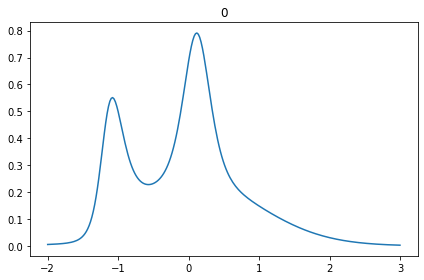

In [142]:
plt.plot(d_grid[:, d].numpy(), marginal.numpy())
plt.title(key)
plt.tight_layout()
plt.show()
plt.close()


In [143]:
import glob

In [144]:
checkpoints = []
configs = []
for directory in glob.glob('../saved_models/25_m1_planar_runs_longer_training/*'):
    checkpoints_ = glob.glob(directory + '/*.ckpt')
    
    
    configs_ = glob.glob(directory + '/*.yml')
    

    if len(checkpoints_) > 0:
        checkpoints.append(checkpoints_[0])
    if len(configs_) > 0:
        configs.append(configs_[0])


In [145]:
models = checkpoints

In [146]:
import yaml

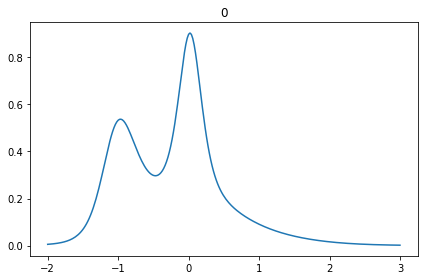

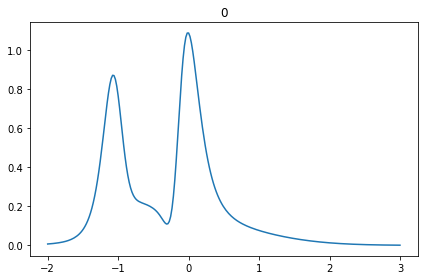

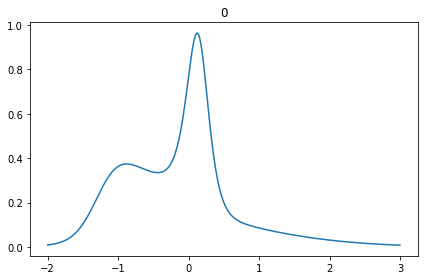

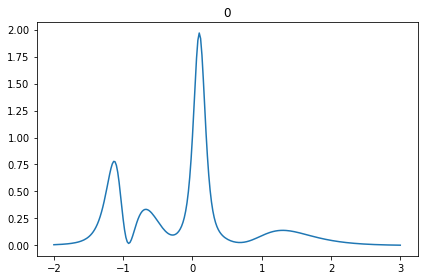

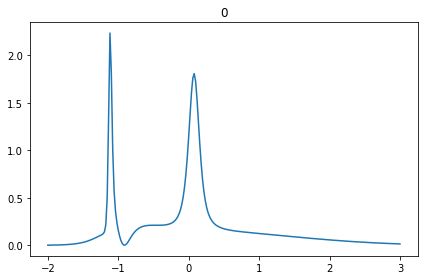

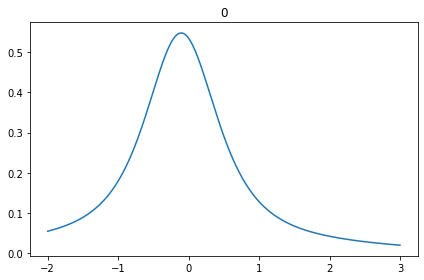

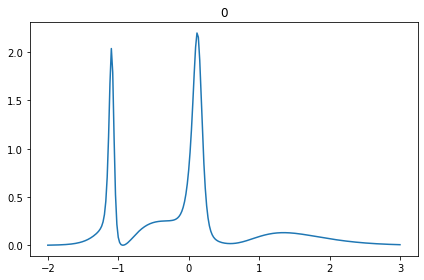

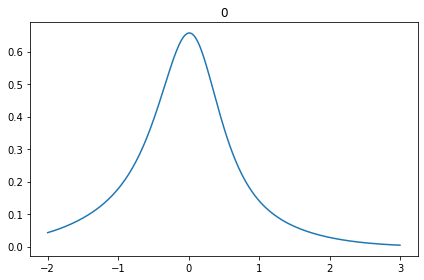

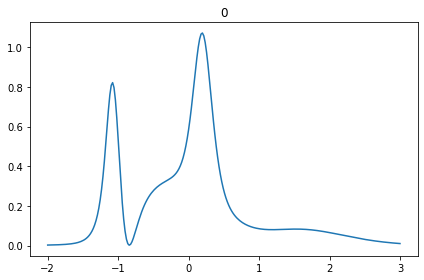

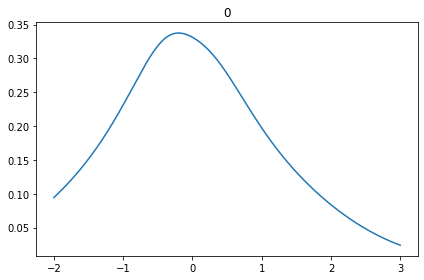

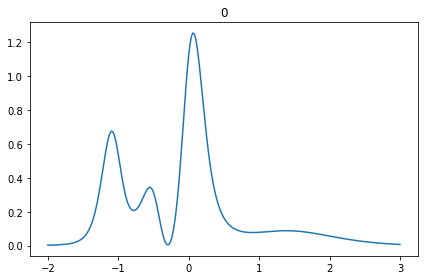

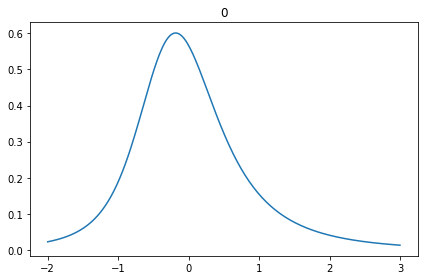

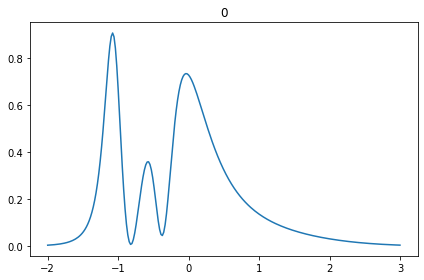

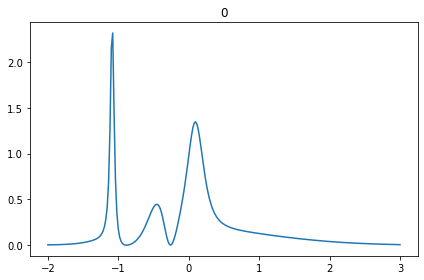

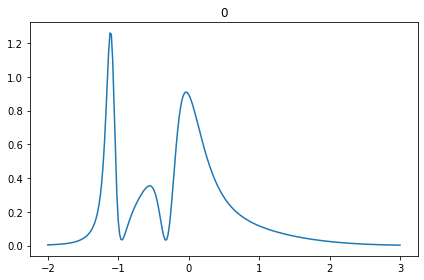

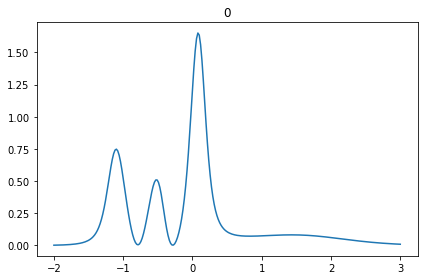

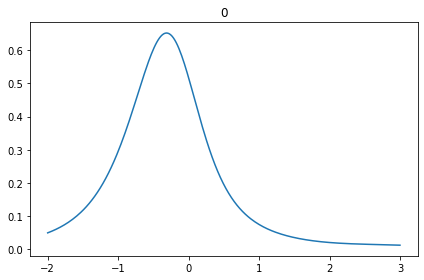

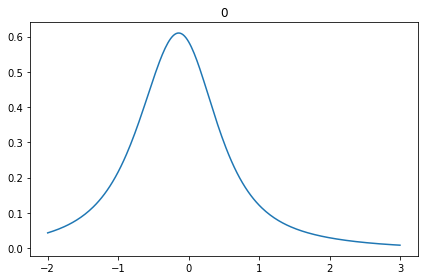

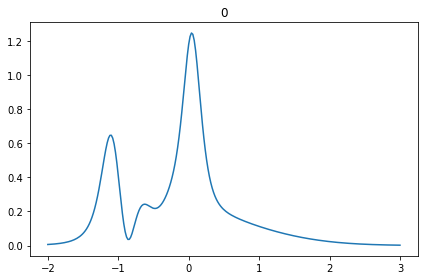

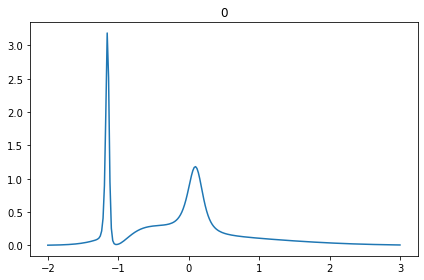

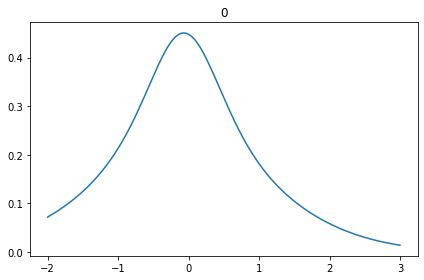

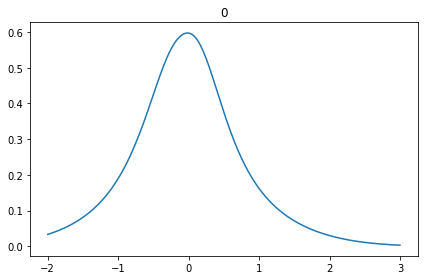

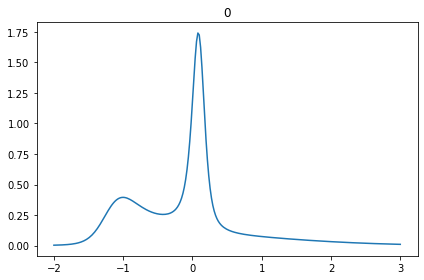

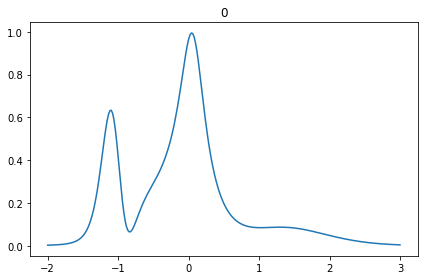

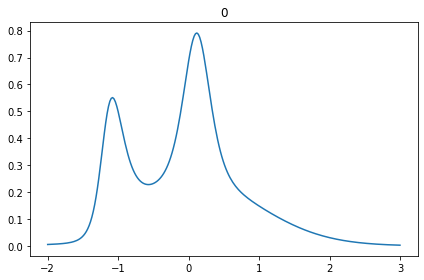

In [147]:
dim = 2
runs = {i: {} for i in range(len(checkpoints))}


for i in range(len(checkpoints)):
    model_path = checkpoints[i]
    config_path = configs[i]
    
    model = HierarchicalNormalizingFlow.load_from_checkpoint(model_path, flows=flows)
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        
    for k in config['command'].rsplit('--'):
        if k.startswith('dataset.fold'):
            runs[i]['fold'] = int(k.split('=')[-1])
    
    runs[i]['seed'] = int(config['seed'])
    
    boundaries = (-2, 3)
    resolution = 256
    d = 1
    normalize = False
    keys = None

    grid = torch.linspace(*boundaries, resolution)
    d_grid = [grid] * d
    meshgrid = torch.meshgrid(*d_grid, indexing="xy")
    x = torch.stack(meshgrid).reshape(d, -1).permute(1, 0)
    shape = [resolution] * d
    prob = model.log_prob(x).exp().view(*shape)


    d_grid = torch.stack(d_grid, dim=-1)
    
    runs[i]['grid'] = grid
    runs[i]['prob'] = prob

    if normalize:
        d_grid = dataset.normalize_inverse(d_grid)

    for d in range(d):

        if keys is not None:
            key = keys[d]
        else:
            key = d

        dimensions_to_sum = list(range(d + 1))
        dimensions_to_sum.pop(d)

        if len(dimensions_to_sum) == 0:
            marginal = prob
        else:
            marginal = prob.sum(dim=tuple(dimensions_to_sum))
        
        plt.plot(d_grid[:, d].numpy(), marginal.numpy())
        plt.title(key)
        plt.tight_layout()
        plt.show()
        plt.close()
        
        runs[i][f'd{d}'] = {'grid': d_grid[:, d].numpy(), 'prob': marginal.numpy()}


    probabilities.append(marginal.numpy())

In [163]:
group_per_fold = {i: {} for i in range(5)}
group_per_seed = {i: {} for i in range(5)}

for i in runs:
    fold = runs[i]['fold']
    group_per_fold[fold]['grid'] = runs[i]['grid']
    if 'prob' not in group_per_fold[fold]:
        group_per_fold[fold]['prob'] = []
    group_per_fold[fold]['prob'].append(runs[i]['prob'])
    
    seed = runs[i]['seed']
    group_per_seed[seed]['grid'] = runs[i]['grid']
    if 'prob' not in group_per_seed[seed]:
        group_per_seed[seed]['prob'] = []
    group_per_seed[seed]['prob'].append(runs[i]['prob'])


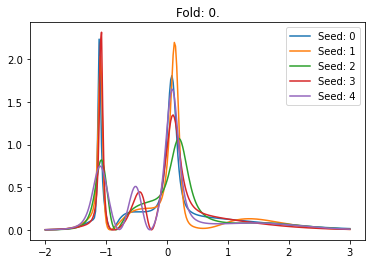

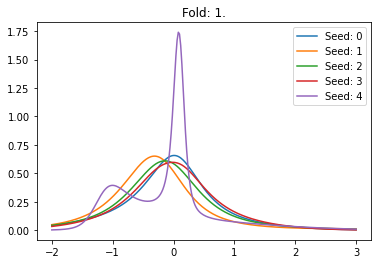

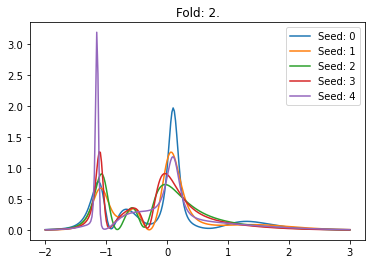

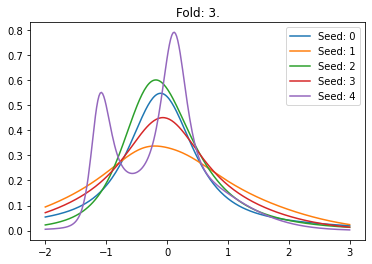

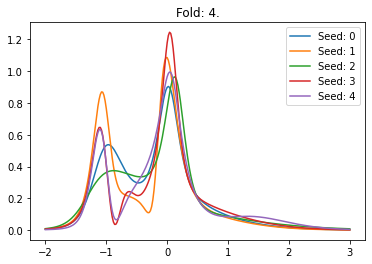

In [171]:
for fold in group_per_fold:
    grid = group_per_fold[fold]['grid']
    prob = np.stack(group_per_fold[fold]['prob'])
    for i in range(5):
        plt.plot(grid, prob[i], label=f"Seed: {i}")
        
    plt.title(f"Fold: {fold}.")
    plt.legend()
    plt.show()
    
    

In [70]:
probabilities = np.stack(probabilities)

In [71]:
mean = np.median(probabilities, axis=0)
std = probabilities.std(0)

In [72]:
q5 = np.quantile(probabilities, 0.05, axis=0)

In [73]:
q95 = np.quantile(probabilities, 0.95, axis=0)

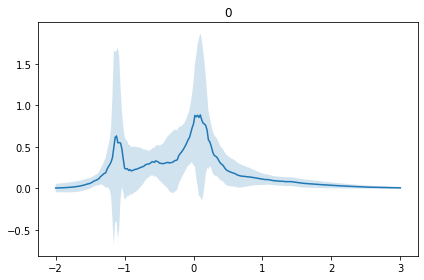

In [74]:
plt.plot(d_grid[:, d].numpy(), mean)
plt.fill_between(d_grid[:, d].numpy(), mean - 2 * std, mean + 2 * std, alpha=0.2)
# plt.plot(d_grid[:, d].numpy(), mean - std)
# plt.plot(d_grid[:, d].numpy(), mean + std)


plt.title(key)
plt.tight_layout()
plt.show()
plt.close()

In [75]:
from data.m1 import M1Dataset

In [76]:
dataset = M1Dataset('../datasets/Combined_GWTC_m1m2chieffz.npz', split='test')

In [77]:
x = dataset.normalize_inverse(d_grid[:, d])

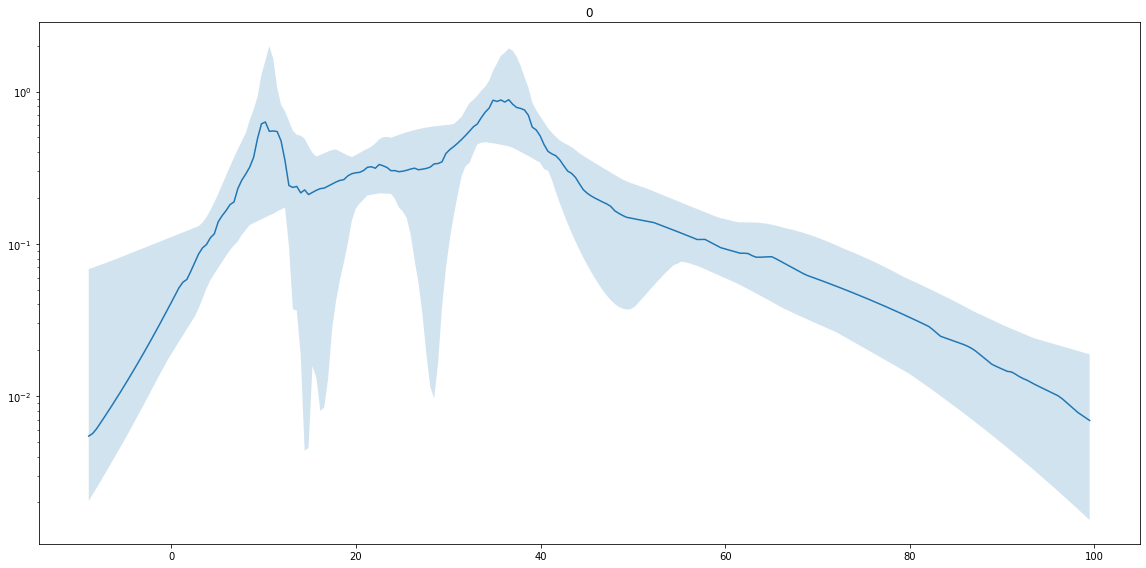

In [78]:
plt.figure(figsize=(16, 8), facecolor='white')
plt.plot(x.numpy(), mean)
plt.fill_between(x.numpy(), q5, q95, alpha=0.2)
plt.title(key)
plt.tight_layout()
plt.yscale('log')
plt.show()
plt.close()

In [188]:
from data.m1 import M1Dataset
import seaborn as sns

In [173]:
m1 = M1Dataset('../datasets/Combined_GWTC_m1m2chieffz.npz', split='train', fold=3)

In [184]:
means = m1[:][0].mean(1)

In [190]:
means = m1.normalize_inverse(means)

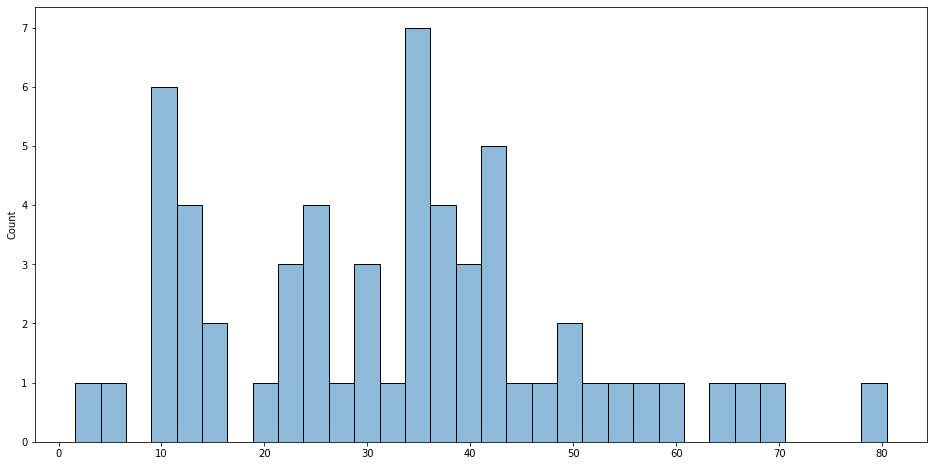

In [198]:
plt.figure(figsize=(16, 8), facecolor='white')
sns.histplot(means, bins=32)
plt.legend([],[], frameon=False)




In [183]:
means.shape

torch.Size([58, 30000, 1])